Carga de librerías

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from yaml import safe_load

Definición de rutas relativas del archivo

In [2]:
ROOT = os.path.dirname(os.getcwd())
DATA = os.path.join(ROOT, 'data')

Carga de archivo de configuración

In [3]:
with open(file=os.path.join(ROOT, 'config.yml'), mode='r') as file:
    CONFIG = safe_load(file)
file.close()

La siguiente sección está basada en el capítulo 3 de- _Data Analysis using Regression and Hierarquical Models_ de Andrew Gelman y Jennifer Hill. La secuencia de los ejercicios en el _notebook_ va en el orden de aparición de los ejemplos en el libro.

# 1. Resultados de un examen para niños

## 1.1. Predictor binario

Para predictores binarios, los coeficientes de regresión lienal represetan la diferencia entre los promedios de dos grupos. Considera el ejemplo en el que se modela los resultados de una prueba de niños, y se proporciona como variable indicadora si sus madres tienen estudios de secundaria ($mother_{hs}$), el modelo que describe los resultados quedaría dado por la expresión:

$$score = 78 + 12 mother_{hs}$$

Este modelo resumen la diferencia entre el resultado promedio de los niños cuya madre no tuvo estudios de secundaria, contra el resultado promedio de aquellos niños cuya madre sí tuvo estudios.

Para ilustrarlo, primero se describen brevemente los datos:

In [4]:
# Ruta a archivo de datos
file_name = os.path.join(DATA, 'kid_iq.csv')

# Carga de datos en un dataframe
kid_iq = pd.read_csv(file_name)

# Eliminar columnas sin nombre
kid_iq.drop(
    columns=[col for col in kid_iq.columns if col.startswith('Unnamed')]
    ,inplace=True)

# Descripción básica de los datos
kid_iq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   kid_score  434 non-null    int64  
 1   mom_hs     434 non-null    int64  
 2   mom_iq     434 non-null    float64
 3   mom_work   434 non-null    int64  
 4   mom_age    434 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 17.1 KB


Ahora se define una función para el modelo de regresión lineal y se generan datos:

In [5]:
# Modelo de regresión lineal
def kid_score(mother_hs): return 78 + 12 * mother_hs

# Datos simulados con el modelo
x = np.linspace(start=0, stop=1, num=100)
y = kid_score(x)

Se puede visualizar el comporamiento del resultado de la prueba condicionado a si la madre concluyó estudios de secundaria, junto con el modelo que describe su comportamiento

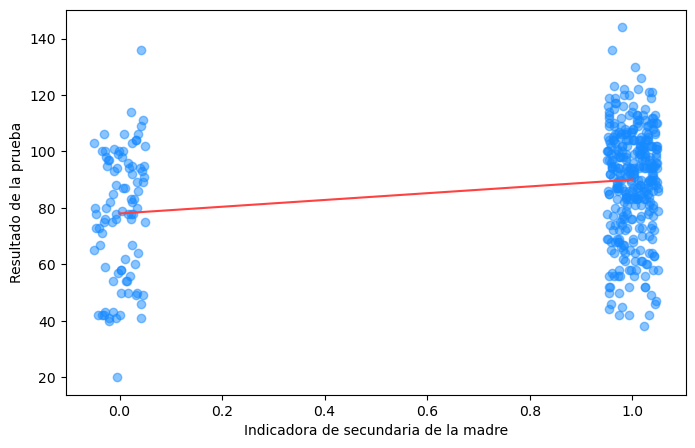

In [6]:
# Configuraciones de figura
fig, ax = plt.subplots(figsize = (8,5))

# Elementos de visualización
ax.scatter(
    x=kid_iq.mom_hs + np.random.uniform(low=-0.05, high=0.05, size=kid_iq.shape[0])
    ,y=kid_iq.kid_score
    ,color=CONFIG['graficas']['colors']['azul']
    ,alpha=0.5)

ax.plot(
    x, y
    ,color=CONFIG['graficas']['colors']['rojo'])

# Anotaciones y estilo
ax.set_xlabel('Indicadora de secundaria de la madre')
ax.set_ylabel('Resultado de la prueba')

plt.show()

## 1.2. Predictor continuo

AHora se investiga cuál es el comportamiento de una variable predictora que es continua, por ejemplo, el IQ de la madre. Para ilustrarlo, se redefine el modelo de regresión lineal:

$$score = 26 + 0.6 mother_{iq}$$

In [7]:
# Modelo de regresión lineal
def kid_score(mother_iq): return 26 + 0.6 * mother_iq

# Datos simulados con el modelo
x = np.linspace(start=70, stop=140, num=100)
y = kid_score(x)

Y nuevamente se visualizan los datos juntos con el modelo de regresión:

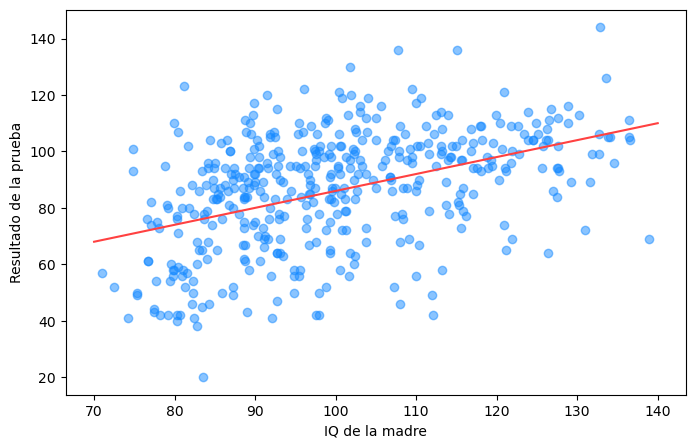

In [8]:
# Configuraciones de figura
fig, ax = plt.subplots(figsize = (8,5))

# Elementos de visualización
ax.scatter(
    x=kid_iq.mom_iq
    ,y=kid_iq.kid_score
    ,color=CONFIG['graficas']['colors']['azul']
    ,alpha=0.5)

ax.plot(
    x, y
    ,color=CONFIG['graficas']['colors']['rojo'])

# Anotaciones y estilo
ax.set_xlabel('IQ de la madre')
ax.set_ylabel('Resultado de la prueba')

plt.show()

## 1.3. Predictores múltiples

A medida que va aumentando el número de predictores lineales, la interpretación de la regresión lineal se empieza a volver más compleja debido a que su interpretación está sujeta al valor de los demás coeficientes. Tomar por ejemplo el caso en el que se mezclan los dos predictores anteriores, es decir:

$$score = 26 + 6 mother_{hs} + 0.6 mother_{iq}$$

En este modelo, para una adecuada interpretación de los coeficientes, y dado que se tiene una variable binaria junto con una variable continua, entonces se tendría que estratificar el modelo por la variable binaria.

Como en los ejemplos anteriores, se empieza por redefinir el modelo de regresión lineal:

In [9]:
# Modelo de regresión lineal
def kid_score(mother_hs, mother_iq): return 26 + 6 * mother_hs + 0.6 * mother_iq

En esta ocasión, el modelo lo aplicamos en el conjunto de datos original:

In [10]:
df = kid_iq[['mom_hs', 'mom_iq', 'kid_score']].copy()
df['kid_score_hat'] = kid_iq.apply(lambda df: kid_score(df.mom_hs, df.mom_iq), axis=1)

Finalmente, visualizamos los datos estratificando por la indicadora de secundaria de la madre:

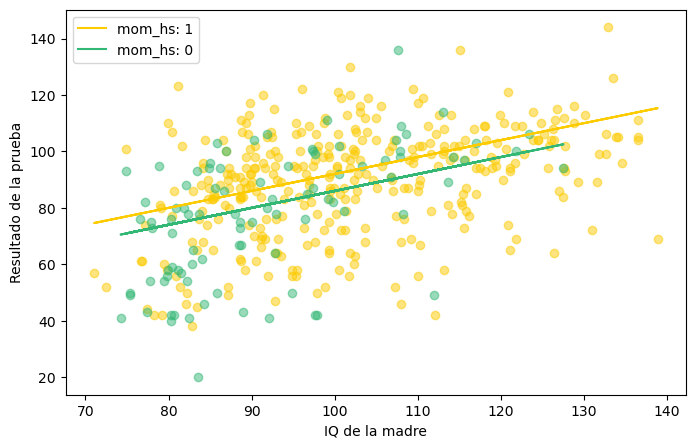

In [11]:
# Configuraciones de figura
fig, ax = plt.subplots(figsize = (8,5))

# Elementos de visualización
for mom_hs in df.mom_hs.unique():
    _df = df.query(f"mom_hs == {mom_hs}")

    ax.scatter(
        x=_df.mom_iq
        ,y=_df.kid_score
        ,alpha=0.5
        ,color=list(CONFIG['graficas']['colors'].values())[mom_hs])
    
    ax.plot(
        _df.mom_iq
        ,_df.kid_score_hat
        ,label=f'mom_hs: {mom_hs}'
        ,color=list(CONFIG['graficas']['colors'].values())[mom_hs])

# Anotaciones y estilo
ax.set_xlabel('IQ de la madre')
ax.set_ylabel('Resultado de la prueba')
ax.legend()

plt.show()

La forma de interpretarlo entonces es la siguiente:

* _Intercepto_: Si la madre tiene un IQ de 0, y no tuvo estudios de secundaria, entonces el resultado esperado para el niño sería de 26 puntos.
* _Coeficiente de indicadora de secundaria de la madre_: Comparando a los niños cuyas madres tienen el mismo IQ pero estratificando por la indicadora de secundaria, el modelo predice una diferencia esperada de 6 puntos en el resultado da las pruebas.
* _Coefieciente de IQ de la madre_: Comparando a los niños cuyas madres se encuentran en el mismo grupo de indicadora de secundaria pero cuyos IQ's difieren en 1 punto, entonces el modelo predice una diferencia esperada de 0.6 puntos en el resultado de las pruebas.